In [11]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import mean_squared_error

## Random Forest 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from copy import deepcopy
import matplotlib.transforms as transforms

from sklearn.linear_model import LinearRegression
from mlxtend.classifier import StackingCVClassifier

import catboost
from catboost import CatBoostRegressor

import xgboost as xgb

SEED = 1337

In [12]:
# config
default_color_1 = 'darkblue'
default_color_2 = 'darkgreen'
default_color_3 = 'darkred'

pd.set_option('display.max_columns', None)

In [13]:
# import training data
t1=time.time()
df_train_data = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv')
t2=time.time()
print('Elapsed time [s]:', np.round(t2-t1,4))

Elapsed time [s]: 13.5513


In [14]:
# read test data
df_test_data = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv')
df_train_scores = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv')

In [15]:
def summary_time(df):
    result = df.groupby('id')['action_time'].sum().reset_index()
    result.rename(columns={'action_time': 'summary_time'}, inplace=True)
    return result
def start_pause(df):
    result = df.groupby('id')['down_time'].min().reset_index()
    result.rename(columns={'down_time': 'start_pause'}, inplace=True)
    return result
def enter_click(df):
    copy_df = df
    copy_df['enter_click'] = (copy_df['down_event'] == 'Enter')
    copy_df = copy_df.groupby('id')['enter_click'].sum().reset_index()
    return copy_df
def space_click(df):
    copy_df = df
    copy_df['space_click'] = (copy_df['down_event'] == 'Space')
    copy_df = copy_df.groupby('id')['space_click'].sum().reset_index()
    return copy_df
def backspace_click(df):
    copy_df = df
    copy_df['backspace_click'] = (copy_df['down_event'] == 'Backspace')
    copy_df = copy_df.groupby('id')['backspace_click'].sum().reset_index()
    return copy_df
def symbol_length(df):
    result = df.groupby('id')['cursor_position'].max().reset_index()
    result.rename(columns={'cursor_position': 'symbol_length'}, inplace=True)
    return result
def text_length(df):
    result = df.groupby('id')['word_count'].max().reset_index()
    return result
def nonproduction_feature(df):
    result = df.groupby('id')['activity'].apply(lambda x: (x == 'Nonproduction').mean() * 100).reset_index()
    result.rename(columns={'activity': 'nonproduction_feature'}, inplace=True)
    return result
def input_feature(df):
    result = df.groupby('id')['activity'].apply(lambda x: (x == 'Input').mean() * 100).reset_index()
    result.rename(columns={'activity': 'input_feature'}, inplace=True)
    return result
def remove_feature(df):
    result = df.groupby('id')['activity'].apply(lambda x: (x == 'Remove/Cut').mean() * 100).reset_index()
    result.rename(columns={'activity': 'remove_feature'}, inplace=True)
    return result
def mean_action_time(df):
    result = df.groupby('id')['action_time'].mean().reset_index()
    result.rename(columns={'action_time': 'mean_action_time'}, inplace=True)
    return result
def replace_feature(df):
    result = df[df['activity'] == 'Replace'].groupby('id').size().reset_index(name='replace_feature')
    return result
def text_change_unique(df):
    result = df.groupby('id')['text_change'].nunique().reset_index()
    result.rename(columns={'text_change': 'tch_unique'}, inplace=True)
    return result
def sentence_size_feature(df):
    result = df[(df['text_change'] == '.') & (df['down_event'] != 'Backspace')].groupby('id').size().reset_index(name = 'number_sentence')
    return result

## (Deletions/Insertions)
def total_deletions(df):
    deletions = df[df['activity'] == 'Delete'].groupby('id').size().reset_index(name='total_deletions')
    return deletions
def total_deletions(df):
    deletions = df[df['activity'].isin(['Remove/Cut', 'Replace'])].groupby('id').size().reset_index(name='total_deletions')
    return deletions
def deletions_per_minute(df):
    deletions_time = df[df['activity'].isin(['Remove/Cut', 'Replace'])].groupby('id')['action_time'].sum().reset_index()
    deletions_count = df[df['activity'].isin(['Remove/Cut', 'Replace'])].groupby('id').size().reset_index(name='count')
    deletions = pd.merge(deletions_time, deletions_count, on='id')
    deletions['deletions_per_minute'] = deletions['count'] / (deletions['action_time'] / 60)
    return deletions[['id', 'deletions_per_minute']]
def length_deletions(df):
    deletions_length = df[df['activity'].isin(['Remove/Cut', 'Replace'])].groupby('id')['text_change'].apply(lambda x: x.str.len().sum()).reset_index()
    deletions_length.rename(columns={'text_change': 'length_deletions'}, inplace=True)
    return deletions_length
def insertions_per_minute(df):
    insertions_time = df[df['activity'] == 'Input'].groupby('id')['action_time'].sum().reset_index()
    insertions_count = df[df['activity'] == 'Input'].groupby('id').size().reset_index(name='count')
    insertions = pd.merge(insertions_time, insertions_count, on='id')
    insertions['insertions_per_minute'] = insertions['count'] / (insertions['action_time'] / 60)
    return insertions[['id', 'insertions_per_minute']]
def length_insertions(df):
    insertions_length = df[df['activity'] == 'Input'].groupby('id')['text_change'].apply(lambda x: x.str.len().sum()).reset_index()
    insertions_length.rename(columns={'text_change': 'length_insertions'}, inplace=True)
    return insertions_length

# Process Variance
def process_variance(df, intervals=5):
    # Calculate total time for each 'id'
    df['total_time'] = df['action_time'].groupby(df['id']).transform('sum')
    
    # Calculate time interval for each 'id'
    df['time_interval'] = df['total_time'] / intervals
    
    # Assign each event to an interval based on its 'down_time'
    df['interval_number'] = (df['down_time'] / df['time_interval']).astype(int) + 1
    df['interval_number'] = df['interval_number'].clip(upper=intervals)  # Ensure max interval is within range
    
    # Calculate characters produced (insertions and deletions) in each interval
    df['chars_produced'] = df['text_change'].str.len()
    chars_per_interval = df.groupby(['id', 'interval_number'])['chars_produced'].sum().reset_index()

    # Calculate proportion of characters produced per interval
    total_chars = chars_per_interval.groupby('id')['chars_produced'].transform('sum')
    chars_per_interval['proportion'] = chars_per_interval['chars_produced'] / total_chars

    # Calculate standard deviation of characters produced per interval for each 'id'
    process_variance = chars_per_interval.groupby('id')['chars_produced'].std().reset_index()
    process_variance.rename(columns={'chars_produced': 'process_variance'}, inplace=True)

    return process_variance

# P-Burst/R-Burst metrics
# Base function to identify P-bursts and R-bursts
def identify_bursts(df):
    df['pause'] = (df['down_time'].diff() > 2).astype(int)
    revision_activities = ['Remove/Cut', 'Replace']
    df['revision'] = df['activity'].isin(revision_activities).astype(int)
    df['P-burst'] = ((df['pause'] == 1) & (df['revision'] == 0)).astype(int)
    df['R-burst'] = df['revision']
    return df
def p_bursts_count(df):
    df = identify_bursts(df)
    result = df.groupby('id')['P-burst'].sum().reset_index()
    result.rename(columns={'P-burst': 'p_bursts_count'}, inplace=True)
    return result
def r_bursts_count(df):
    df = identify_bursts(df)
    result = df.groupby('id')['R-burst'].sum().reset_index()
    result.rename(columns={'R-burst': 'r_bursts_count'}, inplace=True)
    return result
def p_bursts_proportion(df):
    df = identify_bursts(df)
    total_time = df.groupby('id')['action_time'].sum().reset_index()
    p_bursts_time = df[df['P-burst'] == 1].groupby('id')['action_time'].sum().reset_index()
    result = pd.merge(p_bursts_time, total_time, on='id')
    result['p_bursts_proportion'] = result['action_time_x'] / result['action_time_y']
    return result[['id', 'p_bursts_proportion']]
def r_bursts_proportion(df):
    df = identify_bursts(df)
    total_time = df.groupby('id')['action_time'].sum().reset_index()
    r_bursts_time = df[df['R-burst'] == 1].groupby('id')['action_time'].sum().reset_index()
    result = pd.merge(r_bursts_time, total_time, on='id')
    result['r_bursts_proportion'] = result['action_time_x'] / result['action_time_y']
    return result[['id', 'r_bursts_proportion']]
def p_bursts_length(df):
    df = identify_bursts(df)
    df['chars'] = df['text_change'].str.len()
    result = df[df['P-burst'] == 1].groupby('id')['chars'].sum().reset_index()
    result.rename(columns={'chars': 'p_bursts_length'}, inplace=True)
    return result
def r_bursts_length(df):
    df = identify_bursts(df)
    df['chars'] = df['text_change'].str.len()
    result = df[df['R-burst'] == 1].groupby('id')['chars'].sum().reset_index()
    result.rename(columns={'chars': 'r_bursts_length'}, inplace=True)
    return result

In [16]:
# df = df_train_group.merge(right=df_train_scores)
def getDataset(train_df):
    new_df = summary_time(train_df)

#     functions = [
#         start_pause, enter_click, space_click,
#         backspace_click, symbol_length, text_length, nonproduction_feature,
#         input_feature, remove_feature, mean_action_time,replace_feature,text_change_unique, sentence_size_feature
#     ]

    functions = [
            start_pause, enter_click, space_click,
            backspace_click, symbol_length, text_length, nonproduction_feature,
            input_feature, remove_feature, mean_action_time,replace_feature,text_change_unique, 
            sentence_size_feature, total_deletions, deletions_per_minute, length_deletions,
            insertions_per_minute, length_insertions, process_variance,
            p_bursts_count, r_bursts_count, p_bursts_proportion, r_bursts_proportion,
            p_bursts_length, r_bursts_length
        ]

    for func in functions:
        result_df = func(train_df)
        new_df = pd.merge(new_df, result_df, on='id', how='outer')

    return new_df

df = getDataset(df_train_data)
test = getDataset(df_test_data)

df.head(10)

,id,summary_time,start_pause,enter_click,space_click,backspace_click,symbol_length,word_count,nonproduction_feature,input_feature,remove_feature,mean_action_time,replace_feature,tch_unique,number_sentence,total_deletions,deletions_per_minute,length_deletions,insertions_per_minute,length_insertions,process_variance,p_bursts_count,r_bursts_count,p_bursts_proportion,r_bursts_proportion,p_bursts_length,r_bursts_length
0,001519c8,297243,4526,4,357,417,1539,256,4.693000,78.607743,16.308174,116.246774,7.0,17,21.0,424,0.726733,524,0.494808,2010,1385.408243,2132,424,0.882127,0.117769,2973,524
1,0022f953,275391,30623,6,391,260,1676,323,10.350448,78.973105,10.594947,112.221271,1.0,12,15.0,261,0.662212,271,0.488795,1938,1489.724068,2192,261,0.913294,0.085871,3964,271
2,0042269b,421201,4441,17,552,439,2291,404,4.231141,84.985493,10.614120,101.837766,7.0,19,21.0,446,0.798044,970,0.596238,3515,2005.723436,3687,446,0.919547,0.079610,4905,970
3,0059420b,189596,41395,3,243,152,1047,206,6.362468,83.804627,9.704370,121.848329,1.0,10,13.0,152,0.490745,168,0.466297,1304,1238.362359,1375,152,0.893732,0.098019,2065,168
4,0075873a,313702,78470,10,324,517,1402,252,2.844725,76.728566,20.426709,123.943896,NaN,9,23.0,517,0.771661,517,0.437199,1942,1252.333921,2013,517,0.871145,0.128144,2510,517
5,0081af50,179985,42636,3,327,340,1445,275,3.437359,81.139756,15.287200,81.404342,3.0,11,11.0,341,0.847205,366,0.722906,1794,1134.841839,1869,341,0.865222,0.134178,2394,366
6,0093f095,193652,6572,4,257,148,1438,242,1.926346,89.688385,8.385269,109.717847,NaN,9,15.0,148,0.591487,148,0.536810,1583,618.200857,1616,148,0.921245,0.077526,1847,148
7,009e23ab,213548,106549,9,366,219,1768,308,6.587335,83.935402,9.434764,90.755631,1.0,12,18.0,223,0.863616,228,0.622766,1975,1815.768800,2129,223,0.926977,0.072550,3207,228
8,00e048f1,118893,5273,5,245,120,1308,223,2.586751,89.968454,7.444795,75.011356,NaN,6,23.0,118,0.785794,118,0.793324,1426,1312.390186,1466,118,0.923175,0.075782,1746,118
9,00e1f05a,730504,10731,8,1087,1432,4110,739,2.913366,78.520317,18.476872,93.343215,7.0,26,29.0,1453,0.962783,2573,0.642893,6145,2814.681385,6372,1453,0.875949,0.123956,7961,2573


In [17]:
# columns_with_nan = test.columns[test.isna().any()].tolist()
# columns_with_nan

# columns_with_nan = df.columns[df.isna().any()].tolist()
# columns_with_nan

df['replace_feature'].fillna(0,inplace = True)
test['replace_feature'].fillna(0, inplace = True)
df['number_sentence'].fillna(0,inplace = True)
test['number_sentence'].fillna(0, inplace = True)
df['process_variance'].fillna(0, inplace = True)

# replace NaN for deletions + process variance (are these good to have around if we can't 
# extract them on test?)
test['total_deletions'].fillna(0,inplace = True)
test['deletions_per_minute'].fillna(0,inplace = True)
test['length_deletions'].fillna(0,inplace = True)
test['process_variance'].fillna(0, inplace = True)
test['p_bursts_proportion'].fillna(0, inplace = True)
test['r_bursts_proportion'].fillna(0, inplace = True)
test['p_bursts_length'].fillna(0, inplace = True)
test['r_bursts_length'].fillna(0, inplace = True)

df.head(10)

,id,summary_time,start_pause,enter_click,space_click,backspace_click,symbol_length,word_count,nonproduction_feature,input_feature,remove_feature,mean_action_time,replace_feature,tch_unique,number_sentence,total_deletions,deletions_per_minute,length_deletions,insertions_per_minute,length_insertions,process_variance,p_bursts_count,r_bursts_count,p_bursts_proportion,r_bursts_proportion,p_bursts_length,r_bursts_length
0,001519c8,297243,4526,4,357,417,1539,256,4.693000,78.607743,16.308174,116.246774,7.0,17,21.0,424,0.726733,524,0.494808,2010,1385.408243,2132,424,0.882127,0.117769,2973,524
1,0022f953,275391,30623,6,391,260,1676,323,10.350448,78.973105,10.594947,112.221271,1.0,12,15.0,261,0.662212,271,0.488795,1938,1489.724068,2192,261,0.913294,0.085871,3964,271
2,0042269b,421201,4441,17,552,439,2291,404,4.231141,84.985493,10.614120,101.837766,7.0,19,21.0,446,0.798044,970,0.596238,3515,2005.723436,3687,446,0.919547,0.079610,4905,970
3,0059420b,189596,41395,3,243,152,1047,206,6.362468,83.804627,9.704370,121.848329,1.0,10,13.0,152,0.490745,168,0.466297,1304,1238.362359,1375,152,0.893732,0.098019,2065,168
4,0075873a,313702,78470,10,324,517,1402,252,2.844725,76.728566,20.426709,123.943896,0.0,9,23.0,517,0.771661,517,0.437199,1942,1252.333921,2013,517,0.871145,0.128144,2510,517
5,0081af50,179985,42636,3,327,340,1445,275,3.437359,81.139756,15.287200,81.404342,3.0,11,11.0,341,0.847205,366,0.722906,1794,1134.841839,1869,341,0.865222,0.134178,2394,366
6,0093f095,193652,6572,4,257,148,1438,242,1.926346,89.688385,8.385269,109.717847,0.0,9,15.0,148,0.591487,148,0.536810,1583,618.200857,1616,148,0.921245,0.077526,1847,148
7,009e23ab,213548,106549,9,366,219,1768,308,6.587335,83.935402,9.434764,90.755631,1.0,12,18.0,223,0.863616,228,0.622766,1975,1815.768800,2129,223,0.926977,0.072550,3207,228
8,00e048f1,118893,5273,5,245,120,1308,223,2.586751,89.968454,7.444795,75.011356,0.0,6,23.0,118,0.785794,118,0.793324,1426,1312.390186,1466,118,0.923175,0.075782,1746,118
9,00e1f05a,730504,10731,8,1087,1432,4110,739,2.913366,78.520317,18.476872,93.343215,7.0,26,29.0,1453,0.962783,2573,0.642893,6145,2814.681385,6372,1453,0.875949,0.123956,7961,2573


In [18]:
# merge scores
df = pd.merge(df, df_train_scores, on='id', how='outer')
df.head(10)

,id,summary_time,start_pause,enter_click,space_click,backspace_click,symbol_length,word_count,nonproduction_feature,input_feature,remove_feature,mean_action_time,replace_feature,tch_unique,number_sentence,total_deletions,deletions_per_minute,length_deletions,insertions_per_minute,length_insertions,process_variance,p_bursts_count,r_bursts_count,p_bursts_proportion,r_bursts_proportion,p_bursts_length,r_bursts_length,score
0,001519c8,297243,4526,4,357,417,1539,256,4.693000,78.607743,16.308174,116.246774,7.0,17,21.0,424,0.726733,524,0.494808,2010,1385.408243,2132,424,0.882127,0.117769,2973,524,3.5
1,0022f953,275391,30623,6,391,260,1676,323,10.350448,78.973105,10.594947,112.221271,1.0,12,15.0,261,0.662212,271,0.488795,1938,1489.724068,2192,261,0.913294,0.085871,3964,271,3.5
2,0042269b,421201,4441,17,552,439,2291,404,4.231141,84.985493,10.614120,101.837766,7.0,19,21.0,446,0.798044,970,0.596238,3515,2005.723436,3687,446,0.919547,0.079610,4905,970,6.0
3,0059420b,189596,41395,3,243,152,1047,206,6.362468,83.804627,9.704370,121.848329,1.0,10,13.0,152,0.490745,168,0.466297,1304,1238.362359,1375,152,0.893732,0.098019,2065,168,2.0
4,0075873a,313702,78470,10,324,517,1402,252,2.844725,76.728566,20.426709,123.943896,0.0,9,23.0,517,0.771661,517,0.437199,1942,1252.333921,2013,517,0.871145,0.128144,2510,517,4.0
5,0081af50,179985,42636,3,327,340,1445,275,3.437359,81.139756,15.287200,81.404342,3.0,11,11.0,341,0.847205,366,0.722906,1794,1134.841839,1869,341,0.865222,0.134178,2394,366,2.0
6,0093f095,193652,6572,4,257,148,1438,242,1.926346,89.688385,8.385269,109.717847,0.0,9,15.0,148,0.591487,148,0.536810,1583,618.200857,1616,148,0.921245,0.077526,1847,148,4.5
7,009e23ab,213548,106549,9,366,219,1768,308,6.587335,83.935402,9.434764,90.755631,1.0,12,18.0,223,0.863616,228,0.622766,1975,1815.768800,2129,223,0.926977,0.072550,3207,228,4.0
8,00e048f1,118893,5273,5,245,120,1308,223,2.586751,89.968454,7.444795,75.011356,0.0,6,23.0,118,0.785794,118,0.793324,1426,1312.390186,1466,118,0.923175,0.075782,1746,118,3.5
9,00e1f05a,730504,10731,8,1087,1432,4110,739,2.913366,78.520317,18.476872,93.343215,7.0,26,29.0,1453,0.962783,2573,0.642893,6145,2814.681385,6372,1453,0.875949,0.123956,7961,2573,4.5


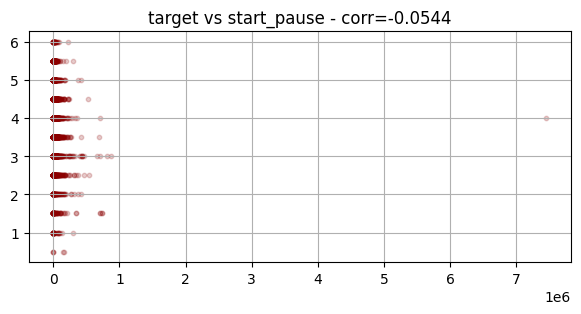

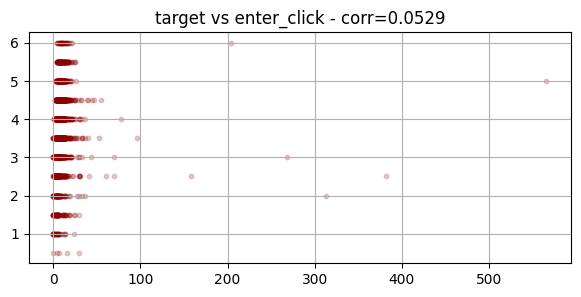

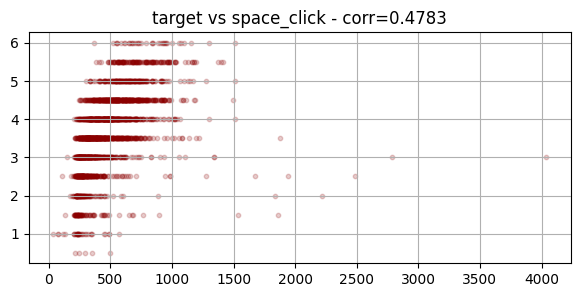

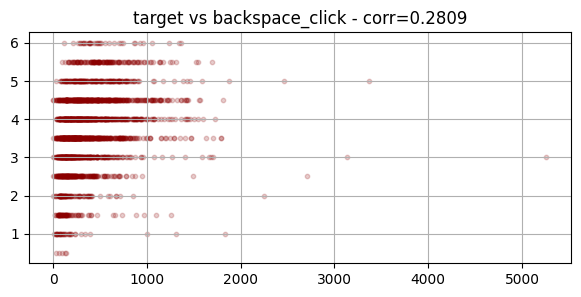

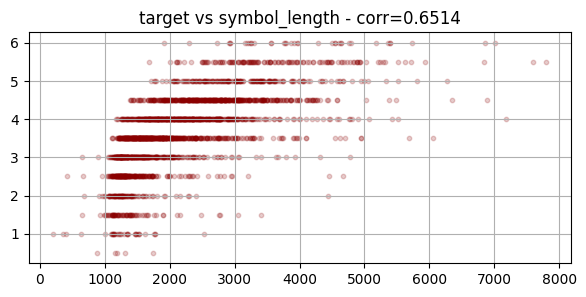

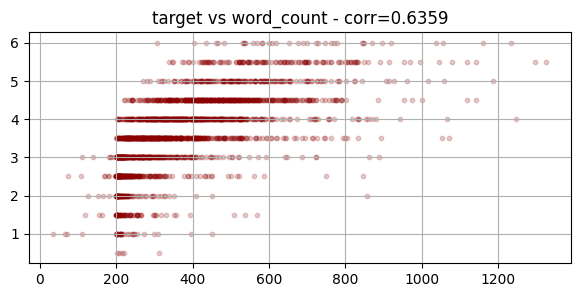

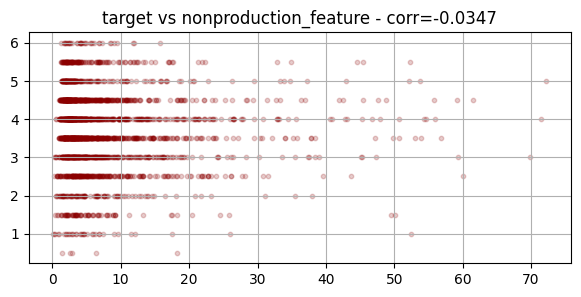

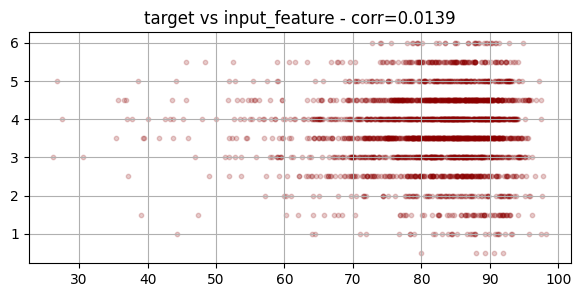

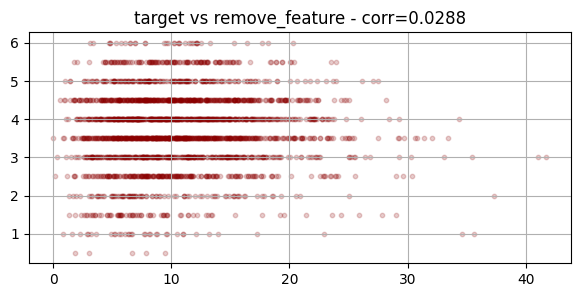

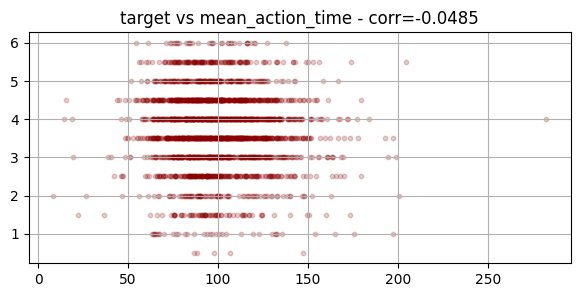

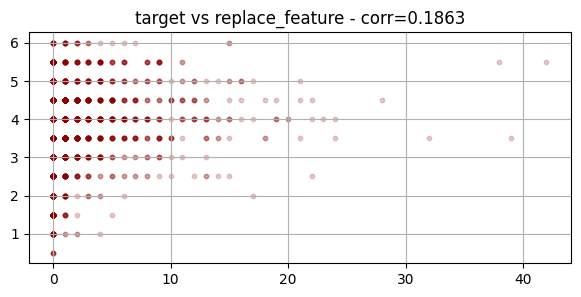

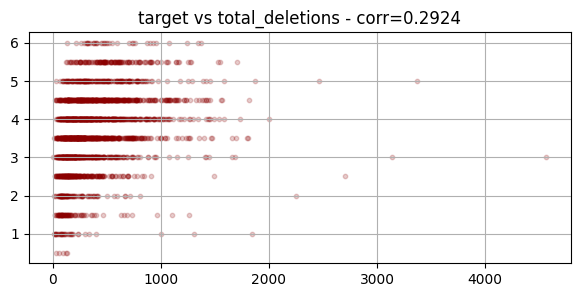

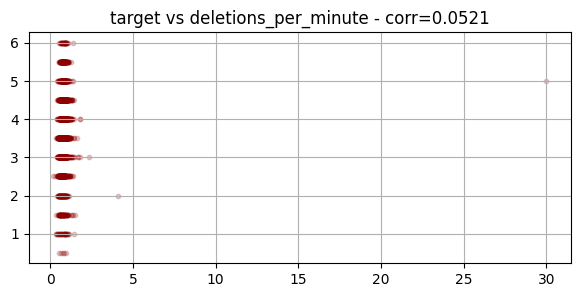

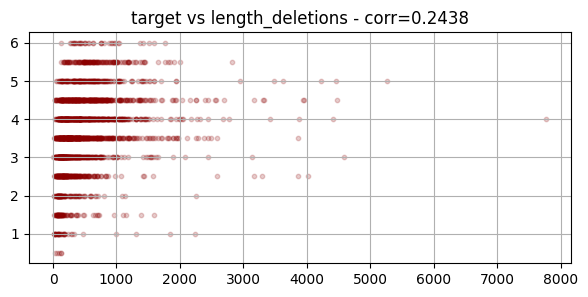

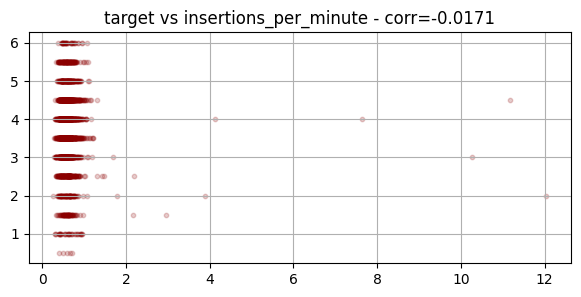

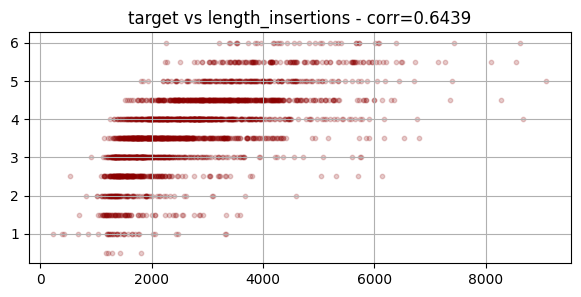

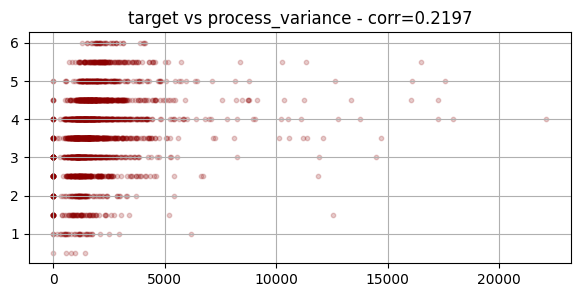

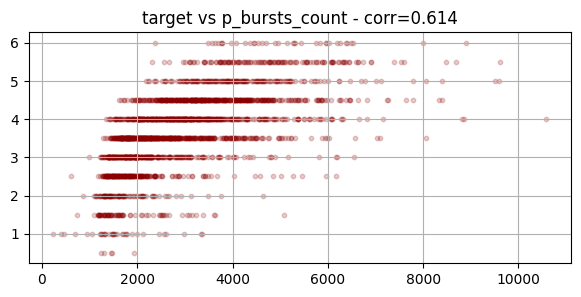

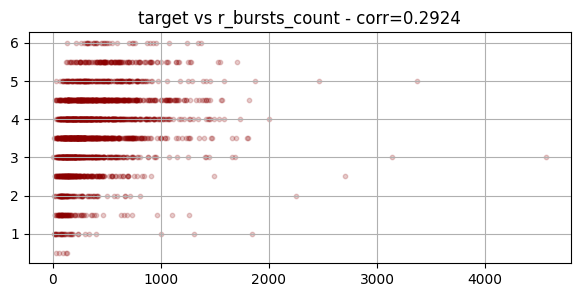

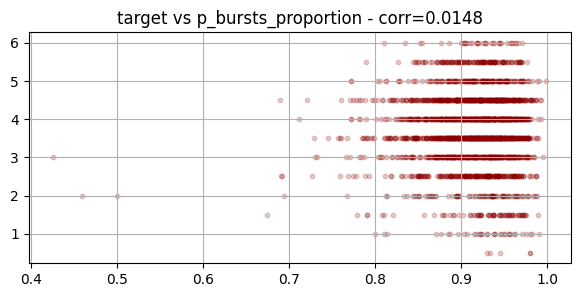

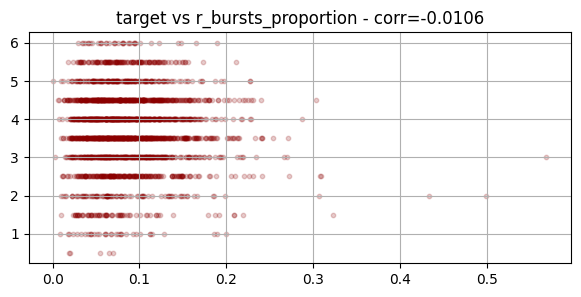

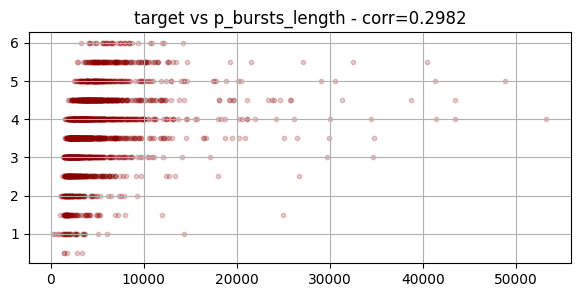

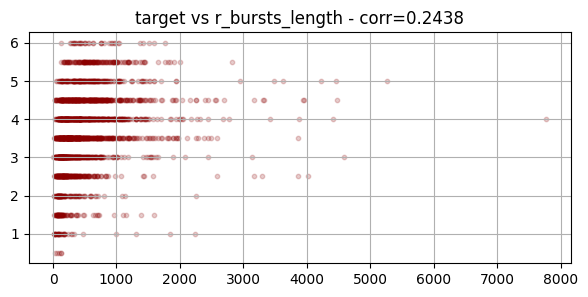

In [19]:
# plot target vs numerical features
features = [
            'start_pause', 'enter_click', 'space_click',
            'backspace_click', 'symbol_length', 'word_count', 'nonproduction_feature',
            'input_feature', 'remove_feature', 'mean_action_time', 'replace_feature',
            'total_deletions', 'deletions_per_minute', 'length_deletions',
            'insertions_per_minute', 'length_insertions', 'process_variance',
            'p_bursts_count', 'r_bursts_count', 'p_bursts_proportion', 'r_bursts_proportion',
            'p_bursts_length', 'r_bursts_length'
        ]

target = 'score'

for f in features:
    plt.figure(figsize=(7,3))
    plt.scatter(df[f], df[target], color=default_color_3, 
                s=10, alpha=0.2)
    c = np.round(df[f].corr(df[target]),4)
    plt.title('target vs ' + f + ' - corr=' + str(c))
    plt.grid()
    plt.show()
    

In [20]:
# for x in df.drop(columns=['score', 'id'],axis=1).columns:
#     Q3 = df[x].quantile(0.75)
#     Q1 = df[x].quantile(0.25)
#     IQR = Q3 - Q1
#     L = Q1 - 1.5*(IQR)
#     U = Q3 + 1.5*(IQR)
#     L_index = list(df.query(f"{x}<{L}").index)
#     df.loc[L_index,x]=L
#     U_index = list(df.query(f"{x}>{U}").index)
#     df.loc[U_index,x]=U  

In [21]:
# # Remove outliners
# test_feats = test_feats.fillna(0)
# for x in test_feats.drop(columns=['id'],axis=1).columns:
#     Q3 = test_feats[x].quantile(0.75)
#     Q1 = test_feats[x].quantile(0.25)
#     IQR = Q3 - Q1
#     L = Q1 - 1.5*(IQR)
#     U = Q3 + 1.5*(IQR)
#     L_index = list(test_feats.query(f"{x}<{L}").index)
#     test_feats.loc[L_index,x]=L
#     U_index = list(test_feats.query(f"{x}>{U}").index)
#     test_feats.loc[U_index,x]=U  

In [22]:
cv_selected_features = ['summary_time', 'start_pause', 'enter_click', 'space_click', 
                        'symbol_length', 'word_count', 'nonproduction_feature', 'tch_unique', 
                        'number_sentence', 'deletions_per_minute', 'insertions_per_minute', 
                        'length_insertions', 'process_variance', 'p_bursts_count', 
                        'r_bursts_proportion', 'p_bursts_length', 'r_bursts_length']

X = df.drop('score', axis=1)
X = X.drop('id',axis=1)
X = X.loc[:, cv_selected_features]
y = df['score']

rf_model = RandomForestRegressor(n_estimators=300, random_state=SEED)
cat_boost= CatBoostRegressor(iterations=1000, 
                          depth=6, 
                          learning_rate=0.1,verbose=False,
                          loss_function='RMSE',random_seed = SEED) 
xgb_boost = xgb.XGBRegressor(objective='reg:squarederror')

# Define meta-model
lr = LinearRegression()

# Stacking classifier
sclf = StackingCVClassifier(classifiers=[rf_model, cat_boost, xgb_boost],
                           meta_classifier=lr,
                           random_state=SEED)

In [23]:
def fit_and_validation(model,X,y):
    scores = []
    models = []
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    np.random.seed(SEED)
    for i, (train_index, valid_index) in enumerate(kf.split(X, y)):

        print(f'Fold #{i}')

        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]

        model = deepcopy(model)

        model = model.fit(X_train, y_train)
        models.append(deepcopy(model))

        X_valid = X.iloc[valid_index]
        y_valid = y.iloc[valid_index]
        y_pred = model.predict(X_valid)
        fold_score = mean_squared_error(y_valid, y_pred)
        scores.append(fold_score)

        print(f'Mean Squared Error: {fold_score}')
    mean = np.mean(scores)
    std = np.std(scores)
    fig, ax = plt.subplots(figsize=(10,3))

    sns.scatterplot(x=scores, y=[0]*len(scores), ax=ax)

    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)

    ax.get_yaxis().set_visible(False)
    plt.axvline(x=mean)
    plt.text(mean+0.0005, 0.7, f'Mean:{mean:.4f}\nStd:{std:.4f}', transform=trans)
    plt.errorbar(x=mean, y=0, xerr=std, color='r')


    sns.despine(right=True, top=True, left=True, ax=ax)

Fold #0
Mean Squared Error: 0.43364531810035845
Fold #1
Mean Squared Error: 0.4333554430949168
Fold #2
Mean Squared Error: 0.4428273616734143
Fold #3
Mean Squared Error: 0.4731392037786775
Fold #4
Mean Squared Error: 0.4794160256410257
Fold #5
Mean Squared Error: 0.4643706702654071
Fold #6
Mean Squared Error: 0.40270607287449395
Fold #7
Mean Squared Error: 0.4902440958164643
Fold #8
Mean Squared Error: 0.49437457264957274
Fold #9
Mean Squared Error: 0.47474308367071527


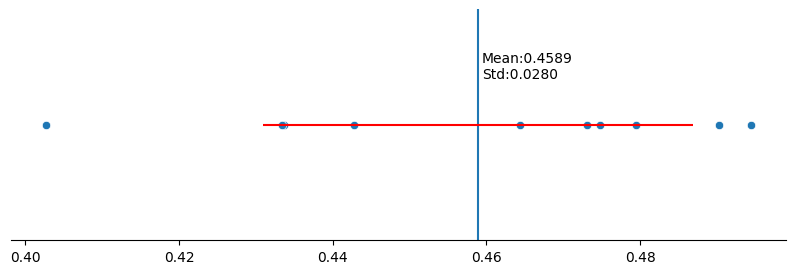

In [24]:
fit_and_validation(rf_model, X,y)

Fold #0
Mean Squared Error: 0.4408320388605743
Fold #1
Mean Squared Error: 0.46091035463242164
Fold #2
Mean Squared Error: 0.4589504813324975
Fold #3
Mean Squared Error: 0.45180858630325366
Fold #4
Mean Squared Error: 0.4679243971240373
Fold #5
Mean Squared Error: 0.5067726196075419
Fold #6
Mean Squared Error: 0.4183736732152617
Fold #7
Mean Squared Error: 0.5341891708595201
Fold #8
Mean Squared Error: 0.5452704200333415
Fold #9
Mean Squared Error: 0.4855233402952934


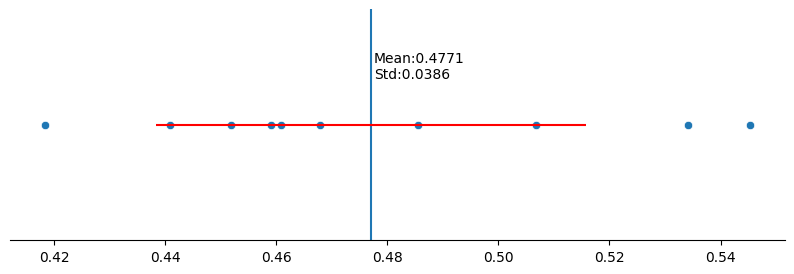

In [25]:
fit_and_validation(cat_boost, X,y)

Fold #0
Mean Squared Error: 0.4813635159350472
Fold #1
Mean Squared Error: 0.48511815463300123
Fold #2
Mean Squared Error: 0.5626437865817266
Fold #3
Mean Squared Error: 0.4993165309222986
Fold #4
Mean Squared Error: 0.5124245968201029
Fold #5
Mean Squared Error: 0.5528872735730702
Fold #6
Mean Squared Error: 0.5086711270687662
Fold #7
Mean Squared Error: 0.5692054047343572
Fold #8
Mean Squared Error: 0.6082453787024653
Fold #9
Mean Squared Error: 0.5130116137012459


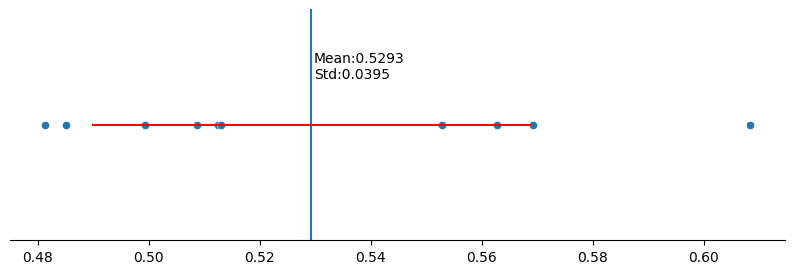

In [26]:
fit_and_validation(xgb_boost, X,y)

Fold #0
Mean Squared Error: 0.4286914743557787
Fold #1
Mean Squared Error: 0.4312099803575473
Fold #2
Mean Squared Error: 0.4337386508724549
Fold #3
Mean Squared Error: 0.4558063843140348
Fold #4
Mean Squared Error: 0.466228357160764
Fold #5
Mean Squared Error: 0.4679148851377938
Fold #6
Mean Squared Error: 0.39480599071613914
Fold #7
Mean Squared Error: 0.4925212526102508
Fold #8
Mean Squared Error: 0.49842336973368195
Fold #9
Mean Squared Error: 0.46408101454765527


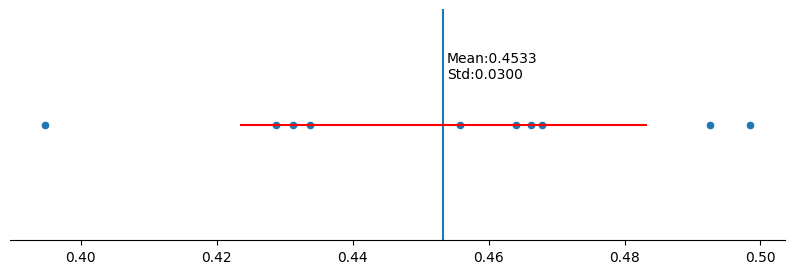

In [27]:
# Stacking Classifier
fit_and_validation(sclf, X,y)

In [28]:
rf_model.fit(X,y)
cat_boost.fit(X,y)
xgb_boost.fit(X,y)
sclf.fit(X,y)

StackingCVClassifier(classifiers=[RandomForestRegressor(n_estimators=300,
                                                        random_state=1337),
                                  <catboost.core.CatBoostRegressor object at 0x7ef9d6be76d0>,
                                  XGBRegressor(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_t...
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               n_estimators=100, n_jobs=None,
                                               num_parallel_tree=None,
                                               predictor=None,
                                               random_state=None, ...)],
                     meta_classifier=LinearRegression(), random_state=1337)

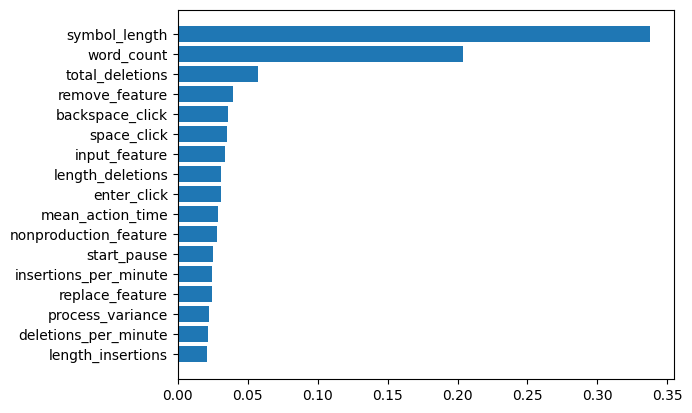

In [29]:
f_i = list(zip(features,rf_model.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

# f_i = list(zip(features,sclf.feature_importances_))
# f_i.sort(key = lambda x : x[1])
# plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

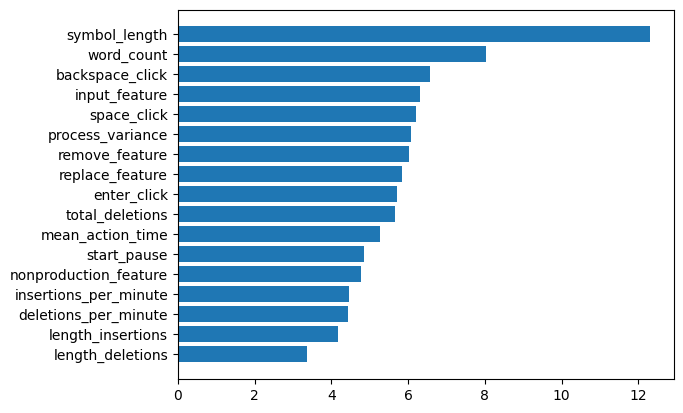

In [30]:
# f_i = list(zip(features,rf_model.feature_importances_))
# f_i.sort(key = lambda x : x[1])
# plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

f_i = list(zip(features,cat_boost.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

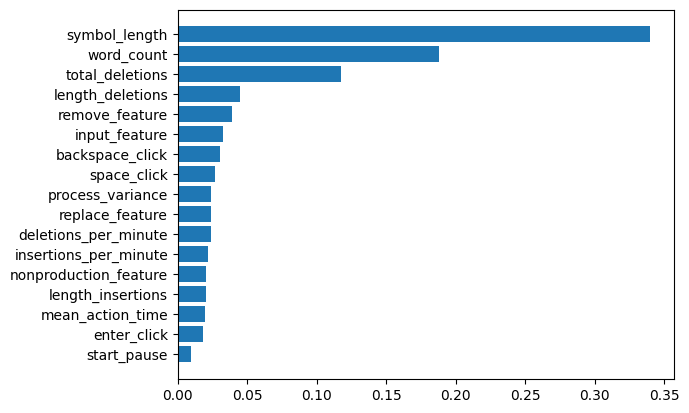

In [31]:
# f_i = list(zip(features,rf_model.feature_importances_))
# f_i.sort(key = lambda x : x[1])
# plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

f_i = list(zip(features,xgb_boost.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

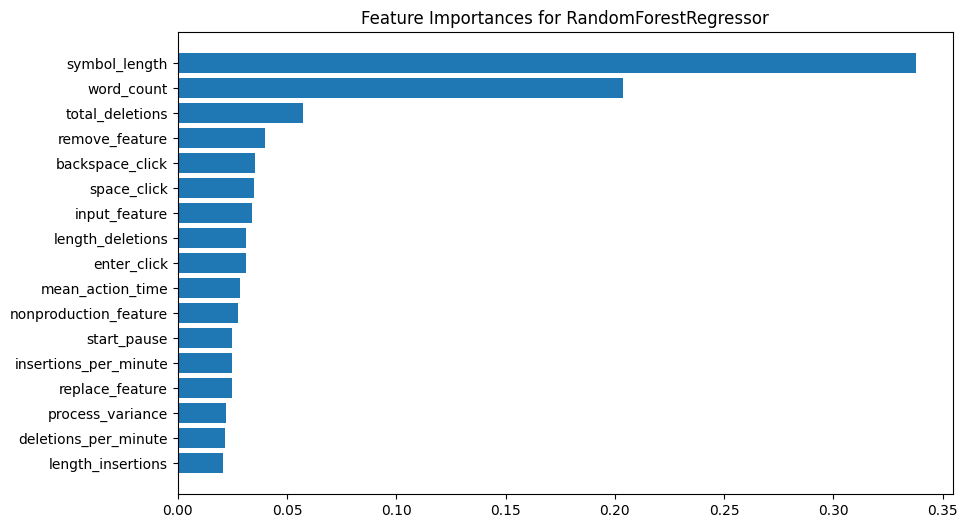

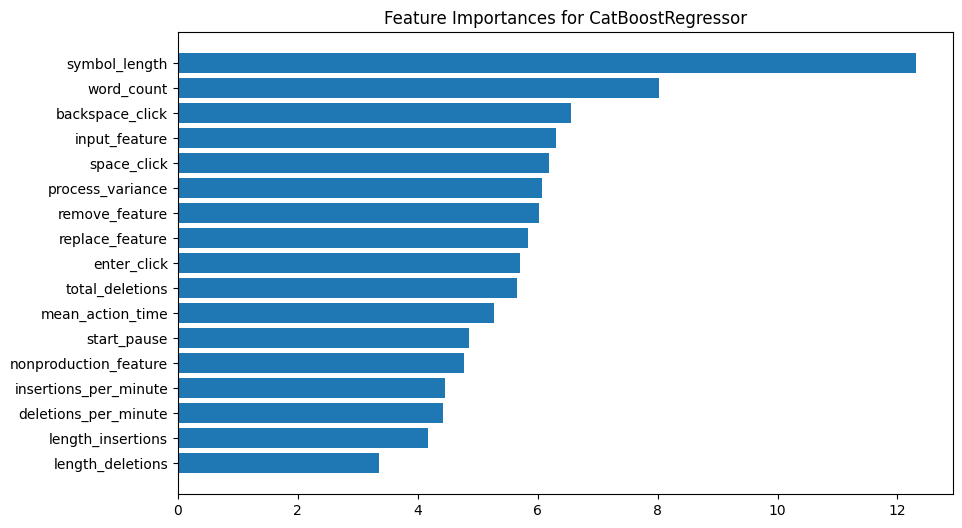

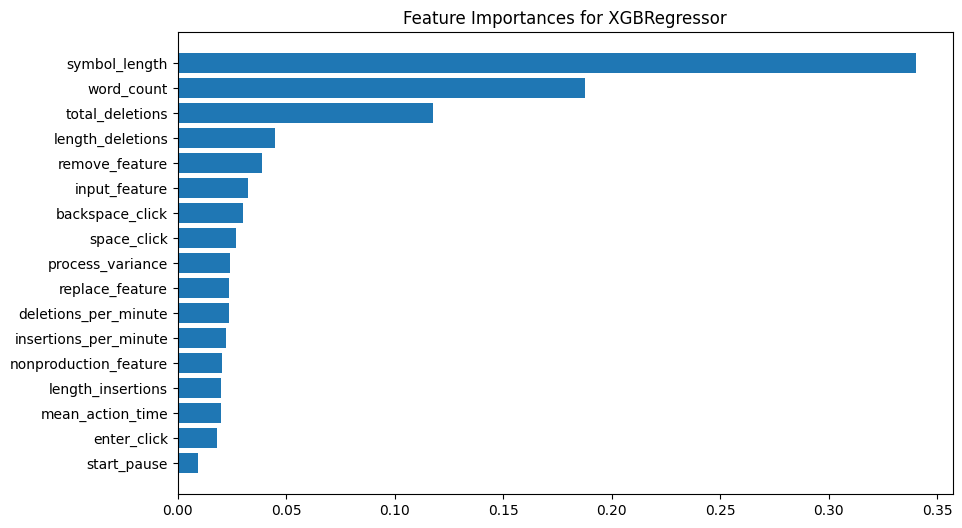

In [32]:
import matplotlib.pyplot as plt

# Assuming you have a list of base classifiers you used to create sclf
# For example:
# base_classifiers = [classifier1, classifier2, ...]
base_classifiers = [rf_model, cat_boost, xgb_boost]

# Iterate through each base classifier
for idx, classifier in enumerate(base_classifiers):
    # Check if the classifier has the feature_importances_ attribute
    if hasattr(classifier, 'feature_importances_'):
        # Assume 'features' is the list of feature names
        f_i = list(zip(features, classifier.feature_importances_))
        f_i.sort(key=lambda x: x[1])

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.barh([x[0] for x in f_i], [x[1] for x in f_i])
        classifier_name = classifier.__class__.__name__
        plt.title(f'Feature Importances for {classifier_name}')
        plt.show()


In [33]:
ids = df['id']
df = df.drop(columns=['id', 'score'])
df = df.loc[:, cv_selected_features]
df

,summary_time,start_pause,enter_click,space_click,symbol_length,word_count,nonproduction_feature,tch_unique,number_sentence,deletions_per_minute,insertions_per_minute,length_insertions,process_variance,p_bursts_count,r_bursts_proportion,p_bursts_length,r_bursts_length
0,297243,4526,4,357,1539,256,4.693000,17,21.0,0.726733,0.494808,2010,1385.408243,2132,0.117769,2973,524
1,275391,30623,6,391,1676,323,10.350448,12,15.0,0.662212,0.488795,1938,1489.724068,2192,0.085871,3964,271
2,421201,4441,17,552,2291,404,4.231141,19,21.0,0.798044,0.596238,3515,2005.723436,3687,0.079610,4905,970
3,189596,41395,3,243,1047,206,6.362468,10,13.0,0.490745,0.466297,1304,1238.362359,1375,0.098019,2065,168
4,313702,78470,10,324,1402,252,2.844725,9,23.0,0.771661,0.437199,1942,1252.333921,2013,0.128144,2510,517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,499670,22467,7,651,1634,461,3.988183,13,43.0,0.855403,0.504180,3588,1880.701518,3776,0.135043,5092,1966
2467,214221,21732,12,447,1877,438,5.683564,8,31.0,0.864227,0.706479,2395,1521.792200,2541,0.019769,3570,66
2468,231580,23482,12,1861,2761,201,4.113614,6,5.0,0.791486,0.796266,2849,1598.223545,2942,0.028806,3810,88
2469,289439,19885,6,457,2133,413,2.190006,13,31.0,0.803923,0.659914,2895,1315.368465,2965,0.071169,3455,343


In [34]:
# predictions = rf_model.predict(df)
predictions = sclf.predict(df)
predictions_df = pd.DataFrame({'id': ids, 'pred_score': predictions})
predictions_df = pd.merge(predictions_df, df_train_scores, on='id')

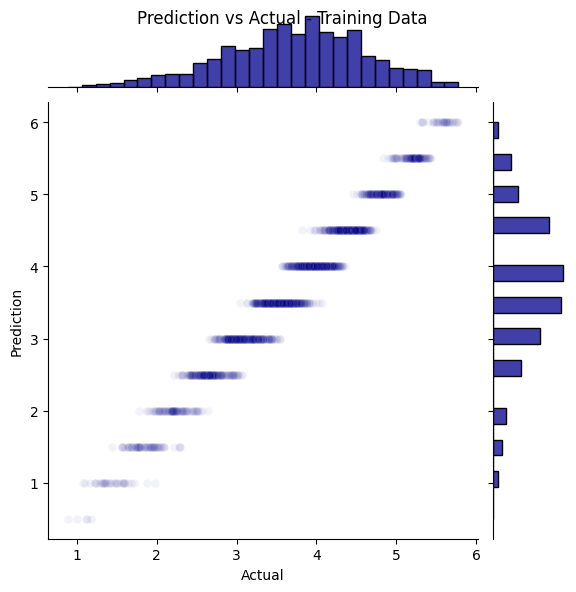

In [35]:

p=sns.jointplot(data=predictions_df, x='pred_score', y='score',
                color=default_color_1,
                joint_kws={'alpha' : 0.05})
# p.ax_joint.axhline(0, color='grey', alpha=0.5)
# p.ax_joint.axvline(0, color='grey', alpha=0.5)
p.fig.suptitle('Prediction vs Actual - Training Data')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

In [36]:
ids = test['id']
test = test.drop(columns=['id'])
test = test.loc[:, cv_selected_features]

In [37]:
# predictions = rf_model.predict(test)
predictions = sclf.predict(test)
predictions_df = pd.DataFrame({'id': ids, 'score': predictions})

In [38]:
predictions_df

,id,score
0,0000aaaa,1.475196
1,2222bbbb,1.420727
2,4444cccc,1.436199


In [39]:
predictions_df.to_csv('submission.csv', index=False)